### Run onece, to check environment

In [1]:
#!pip3 install -r requirements.txt

### Scraper part, no need to run, just in case, can be adapted to other datasource
* Fit Erik's code into Scrapy(20 minutes now). Scraping publish time of news.

* To run it, put 'MINDlarge_train' in the top level directory of the project, which is 'DM-project'
  * don't submit MINDlarge_train, add it to gitignore

* Output filepath is 'DM-project/generate/newstimes.csv'

* Don't forget to go back to the top level directory

In [2]:
#%cd scraper

In [3]:
#!scrapy crawl news

In [4]:
#%cd ..

In [5]:
newsTimes = 'generate/newstimes.csv'

### Load Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

In [7]:
behaviors = 'MINDlarge_train/behaviors.tsv'
news = 'MINDlarge_train/news.tsv'
entityEmbedding = 'MINDlarge_train/entity_embedding.vec'

### Preprocssing, run once

In [8]:
import preprocessing.preprocessing as pre

In [9]:
#generate news_embedding.csv, news_cleaned.csv
#pre.createNews(news,newsTimes,entityEmbedding)

#generate user_history.csv, user_impression.csv
#pre.createUsers(behaviors)

(42007, 101)


### Categorical Embedding capture trending

In [7]:
df_news = pd.read_csv('generate/news_cleaned.csv')
df_embeddings = pd.read_csv('generate/news_embedding.csv')

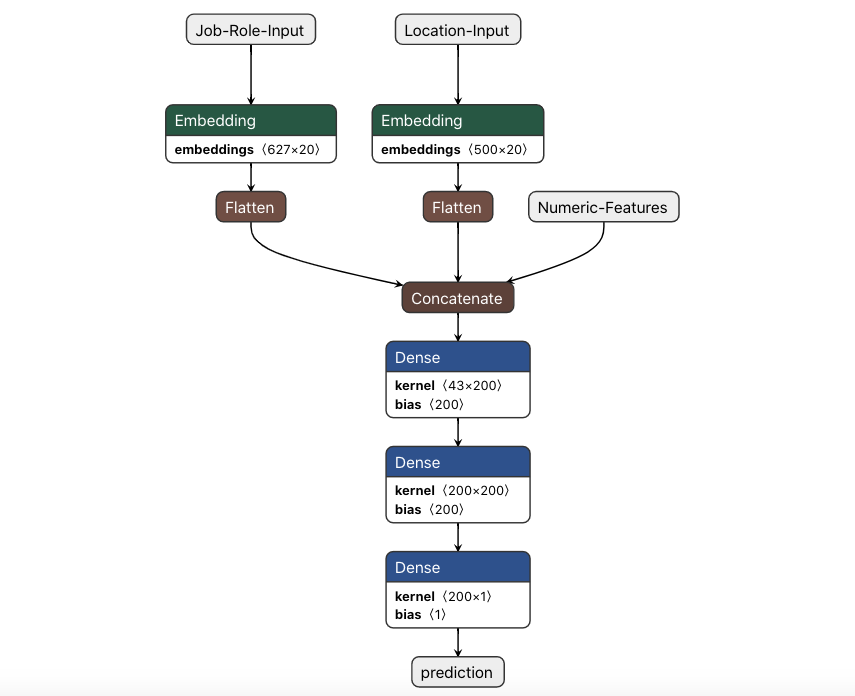

The idea is make some native prediction, get embedding weights.
The image is from somewhere else, but just pick the idea

TBC.....

In [10]:
#embedding_size = 3
#model = models.Sequential()
#model.add(Embedding(input_dim = len(subcategories), output_dim = embedding_size, input_length = 1, name="embedding"))
#model.add(Flatten())
#model.add(Dense(50, activation="relu"))
#model.add(Dense(15, activation="relu"))
#model.add(Dense(1))
#model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
#model.fit(x = df['x'].as_matrix(), y=df['y'].as_matrix() , epochs = 50, batch_size = 4)

In [143]:
df_merged = df_news.merge(df_embeddings,on='NID')

In [144]:
vectorColumns = [c for c in df_embeddings.columns if c!='NID']